# Прогнозирование оттока клиентов для сети фитнес-центров

**Цель проекта** - проведение анализа клиентской базы фитнес-клуба, разработка модели прогноза оттока на уровне клиента и формулирование рекомендаций заказчику по снижению оттока. 
    
Массив данных содержит в себе информацию о посетителях клуба (пол, возраст, срок абонемента, срок с момента первого посещения, частота занятий, сведения об участии в промо-акциях, посещении групповых зантий и пр.).

В ходе исследования решается ряд **задач**:
- подготовка данных; 
- проведение анализа признаков в разрезе оттока;
- определение корреляции между признаками и целевой переменной;
- построение моделей прогнозирования: логистической регрессии и случайного леса;
- кластеризация клиентов, построение портрета целевого клиента;
- формулирование выводов и разработка рекомендаций по снижению оттока и повышению качества работы с клиентами.

---

Импорт библиотек, которые потребуются для выполнения исследования:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

# Загрузка датасета

Считывание файлов с данными в датафрейм:

In [2]:
gym_churn = pd.read_csv('/datasets/gym_churn.csv')

Получение данных о первых 10 строках таблицы **gym_churn**:

In [3]:
gym_churn.head(10)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0


Общая информация о данных таблицы **gym_churn**:

In [4]:
gym_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


В датафрейме **gym_churn** представлена информация о клиентах сети фитнес-центров. В нем 14 столбцов: 

- **gender** - пол / целочисл. тип данных
- **Near_Location** - проживание или работа в районе, где находится фитнес-центр / целочисл. тип данных
- **Partner** - сотрудник компании-партнёра клуба / целочисл. тип данных
- **Promo_friends** - факт первоначальной записи в рамках акции «Приведи друга» / целочисл. тип данных
- **Phone** - наличие контактного телефона / целочисл. тип данных
- **Contract_period** - длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год) / целочисл. тип данных
- **Group_visits** - факт посещения групповых занятий / целочисл. тип данных
- **Age** - возраст / целочисл. тип данных
- **Avg_additional_charges_total** - суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон / числа с плав. точкой
- **Month_to_end_contract** - срок до окончания текущего действующего абонемента (в месяцах) / числа с плав. точкой
- **Lifetime** - время с момента первого обращения в фитнес-центр (в месяцах) / целочисл. тип данных
- **Avg_class_frequency_total** - средняя частота посещений в неделю за все время с начала действия абонемента / числа с плав. точкой
- **Avg_class_frequency_current_month** - средняя частота посещений в неделю за предыдущий месяц / числа с плав. точкой
- **Churn** - факт оттока в текущем месяце / целочисл. тип данных

Общее количество записей о посетителях - 4000. Пропусков нет.

---

# Исследовательский анализ данных

Подготовим исходные данные для дальнейшего исседования и построения прогноза.

#### Переименование столбцов

Переименуем столбцы в соответствии с общепринятой практикой:

In [5]:
gym_churn.columns = gym_churn.columns.str.lower()
gym_churn.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

#### Удаление дубликатов

Проверим таблицу на наличие полностью повторяющихся строк:

In [6]:
gym_churn.duplicated().sum()

0

Полных дубликатов в данных нет. 

#### Анализ признаков

Теперь рассмотрим отдельно каждый столбец на предмет наличия ошибок в данных, аномалий и пр. Начнем с основного показателя (в дальнейшем - целевой переменной) - оттока.

**churn - факт оттока в текущем месяце**

In [7]:
gym_churn['churn'].value_counts()

0    2939
1    1061
Name: churn, dtype: int64

В отток попало более четверти клиентов.

In [8]:
ch = gym_churn.groupby(by = 'churn').agg({'gender' : 'count'}).reset_index()\
                         .rename(columns = {'gender':'n'}).sort_values(by = 'n', ascending = False)
ch['label'] = ['Нет' if (i == 0) else 'Да' for i in ch['churn']]

In [9]:
#вспомогательная функция для отображения процентов на графике
def show_percent(figure, shift, height):
    
    totals = []
    for i in figure.patches:
        totals.append(i.get_height())
    
    total = sum(totals)

    for i in figure.patches:
        figure.text(i.get_x() + shift, i.get_height() + height, \
            str(round((i.get_height() / total) * 100, 2)) + '%', fontsize=12,
                color = 'black')

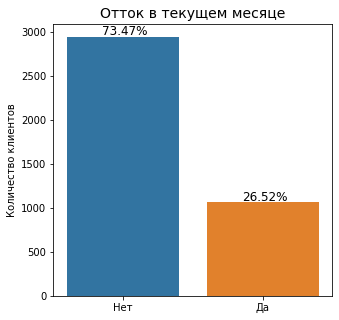

In [10]:
plt.figure(figsize=(5, 5))
fig = sns.barplot(x = "label", y = "n", data = ch) 
fig.set_title("Отток в текущем месяце", fontsize = 14)
fig.set_ylabel("Количество клиентов", fontsize = 10)
fig.set_xlabel("")
show_percent(fig, 0.25, 20)

In [11]:
gym_churn['churn'].describe()

count    4000.000000
mean        0.265250
std         0.441521
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: churn, dtype: float64

Среднее значение - 0,26. Стандартное отклонение - 0,44.

Для дальнейшего удобства разобьем датасет на две группы - тех, кто ушел в отток, и тех, кто не ушел:

In [12]:
churn_clients = gym_churn.query('churn == 1')
nonchurn_clients = gym_churn.query('churn == 0')

Будем рассматривать каждый признак в разрезе оттока.

**gender - пол**

In [13]:
gym_churn['gender'].value_counts()

1    2041
0    1959
Name: gender, dtype: int64

Переменная принимает два значения: 1 или 0 (информации о том, какой показатель какому полу соответствует, нет). Группы распределились примерно пополам:

In [14]:
gend = gym_churn.groupby(by = 'gender').agg({'churn' : 'count'}).reset_index()\
                         .rename(columns = {'churn':'n'}).sort_values(by = 'n', ascending = False)

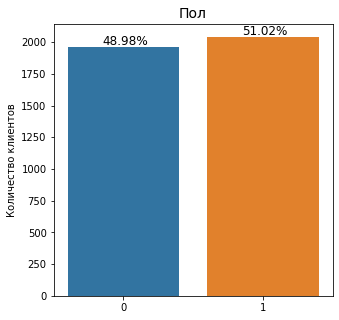

In [15]:
plt.figure(figsize=(5, 5))
fig = sns.barplot(x = "gender", y = "n", data = gend) 
fig.set_title("Пол", fontsize = 14)
fig.set_ylabel("Количество клиентов", fontsize = 10)
fig.set_xlabel("")
show_percent(fig, 0.25, 20)

In [16]:
gym_churn['gender'].describe()

count    4000.000000
mean        0.510250
std         0.499957
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: gender, dtype: float64

Среднее значение - 0,51. Стандартное отклонение - 0,50.

Средние значения признака **gender** в группах с оттоком и без оттока практически равны:

In [17]:
churn_clients['gender'].mean().round(3)

0.511

In [18]:
nonchurn_clients['gender'].mean().round(3)

0.51

In [19]:
gend_c = churn_clients.groupby(by = 'gender').agg({'churn' : 'count'}).reset_index()\
                         .rename(columns = {'churn':'n'}).sort_values(by = 'n', ascending = False)
gend_nc = nonchurn_clients.groupby(by = 'gender').agg({'churn' : 'count'}).reset_index()\
                         .rename(columns = {'churn':'n'}).sort_values(by = 'n', ascending = False)

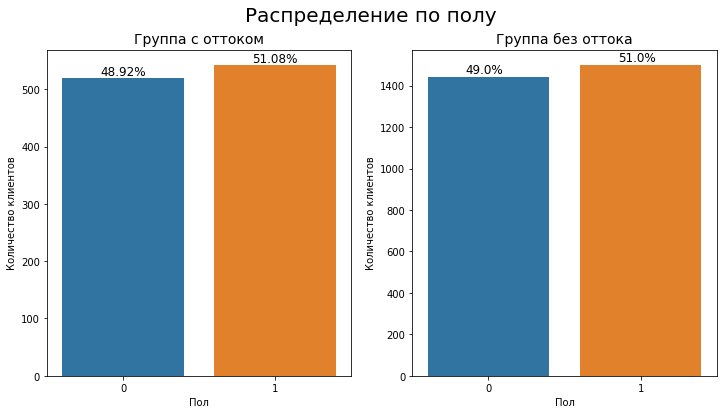

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

fig.suptitle('Распределение по полу', fontsize = 20)

fig1 = sns.barplot(ax = axes[0], x = "gender", y = "n", data = gend_c) 
fig1.set_title("Группа с оттоком", fontsize = 14)
fig1.set_ylabel("Количество клиентов", fontsize = 10)
fig1.set_xlabel("Пол")
show_percent(fig1, 0.25, 5)

fig2 = sns.barplot(ax = axes[1], x = "gender", y = "n", data = gend_nc) 
fig2.set_title("Группа без оттока", fontsize = 14)
fig2.set_ylabel("Количество клиентов", fontsize = 10)
fig2.set_xlabel("Пол")
show_percent(fig2, 0.25, 20)

plt.show()

Разница по половому признаку между группами с оттоком и без практически отсутствует.

**near_location - проживание или работа в районе, где находится фитнес-центр**

In [21]:
gym_churn['near_location'].value_counts()

1    3381
0     619
Name: near_location, dtype: int64

Большая часть клиентов проживает или работает рядом с фитнес-центром.

In [22]:
nl = gym_churn.groupby(by = 'near_location').agg({'gender' : 'count'}).reset_index()\
                         .rename(columns = {'gender':'n'}).sort_values(by = 'n', ascending = False)
nl['label'] = ['Далеко' if (i == 0) else 'Рядом' for i in nl['near_location']]

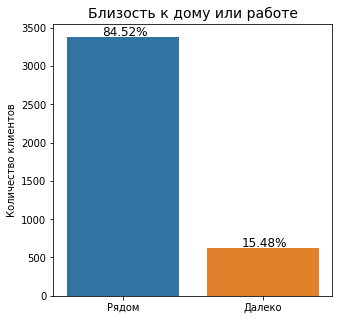

In [23]:
plt.figure(figsize=(5, 5))
fig = sns.barplot(x = "label", y = "n", data = nl) 
fig.set_title("Близость к дому или работе", fontsize = 14)
fig.set_ylabel("Количество клиентов", fontsize = 10)
fig.set_xlabel("")
show_percent(fig, 0.25, 20)

In [24]:
gym_churn['near_location'].describe()

count    4000.000000
mean        0.845250
std         0.361711
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: near_location, dtype: float64

Среднее значение - 0,84. Стандартное отклонение - 0,36.

Средние значения признака **near_location** отличаются в пользу группы без оттока:

In [25]:
churn_clients['near_location'].mean().round(3)

0.768

In [26]:
nonchurn_clients['near_location'].mean().round(3)

0.873

In [27]:
nl_c = churn_clients.groupby(by = 'near_location').agg({'gender' : 'count'}).reset_index()\
                         .rename(columns = {'gender':'n'}).sort_values(by = 'n', ascending = False)
nl_nc = nonchurn_clients.groupby(by = 'near_location').agg({'gender' : 'count'}).reset_index()\
                         .rename(columns = {'gender':'n'}).sort_values(by = 'n', ascending = False)
nl_c['label'] = ['Далеко' if (i == 0) else 'Рядом' for i in nl['near_location']]
nl_nc['label'] = ['Далеко' if (i == 0) else 'Рядом' for i in nl['near_location']]

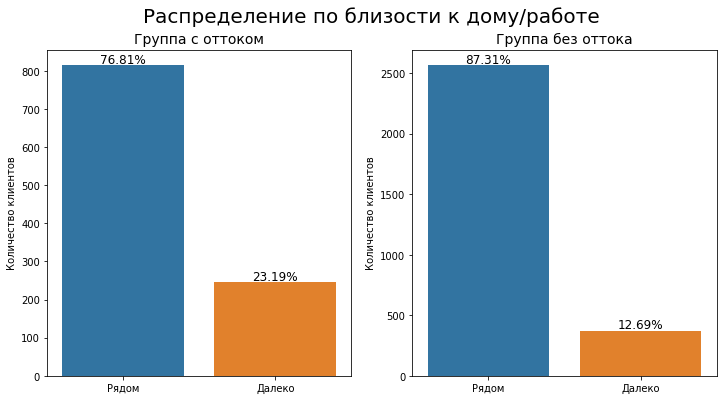

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

fig.suptitle('Распределение по близости к дому/работе', fontsize = 20)

fig1 = sns.barplot(ax = axes[0], x = "label", y = "n", data = nl_c) 
fig1.set_title("Группа с оттоком", fontsize = 14)
fig1.set_ylabel("Количество клиентов", fontsize = 10)
fig1.set_xlabel("")
show_percent(fig1, 0.25, 5)

fig2 = sns.barplot(ax = axes[1], x = "label", y = "n", data = nl_nc) 
fig2.set_title("Группа без оттока", fontsize = 14)
fig2.set_ylabel("Количество клиентов", fontsize = 10)
fig2.set_xlabel("")
show_percent(fig2, 0.25, 20)

plt.show()

Доля клиентов, посещающих фитнес-центр, который находится далеко и от дома и работы, ожидаемо выше в группе оттока. 

**partner - сотрудник компании-партнёра клуба**

In [29]:
gym_churn['partner'].value_counts()

0    2053
1    1947
Name: partner, dtype: int64

Почти половина клиентов является сотрудником компании-партнера, а значит может получать скидки на абонемент.

In [30]:
ptn = gym_churn.groupby(by = 'partner').agg({'gender' : 'count'}).reset_index()\
                         .rename(columns = {'gender':'n'}).sort_values(by = 'n', ascending = False)
ptn['label'] = ['Не партнер' if (i == 0) else 'Партнер' for i in ptn['partner']]

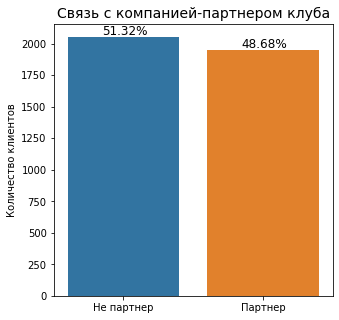

In [31]:
plt.figure(figsize=(5, 5))
fig = sns.barplot(x = "label", y = "n", data = ptn) 
fig.set_title("Связь с компанией-партнером клуба", fontsize = 14)
fig.set_ylabel("Количество клиентов", fontsize = 10)
fig.set_xlabel("")
show_percent(fig, 0.25, 20)

In [32]:
gym_churn['partner'].describe()

count    4000.000000
mean        0.486750
std         0.499887
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: partner, dtype: float64

Среднее значение - 0,49. Стандартное отклонение - 0,50.

Средние значения признака **partner** отличаются в пользу группы без оттока:

In [33]:
churn_clients['partner'].mean().round(3)

0.355

In [34]:
nonchurn_clients['partner'].mean().round(3)

0.534

In [35]:
ptn_c = churn_clients.groupby(by = 'partner').agg({'gender' : 'count'}).reset_index()\
                         .rename(columns = {'gender':'n'}).sort_values(by = 'n', ascending = False)
ptn_nc = nonchurn_clients.groupby(by = 'partner').agg({'gender' : 'count'}).reset_index()\
                         .rename(columns = {'gender':'n'}).sort_values(by = 'n', ascending = False)
ptn_c['label'] = ['Не партнер' if (i == 0) else 'Партнер' for i in ptn['partner']]
ptn_nc['label'] = ['Не партнер' if (i == 0) else 'Партнер' for i in ptn['partner']]

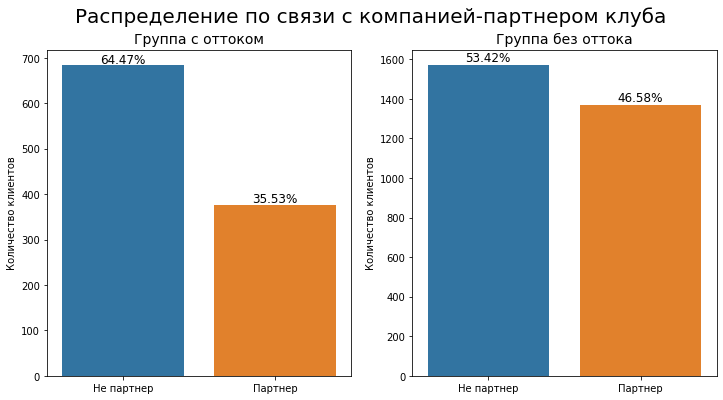

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

fig.suptitle('Распределение по связи с компанией-партнером клуба', fontsize = 20)

fig1 = sns.barplot(ax = axes[0], x = "label", y = "n", data = ptn_c) 
fig1.set_title("Группа с оттоком", fontsize = 14)
fig1.set_ylabel("Количество клиентов", fontsize = 10)
fig1.set_xlabel("")
show_percent(fig1, 0.25, 5)

fig2 = sns.barplot(ax = axes[1], x = "label", y = "n", data = ptn_nc) 
fig2.set_title("Группа без оттока", fontsize = 14)
fig2.set_ylabel("Количество клиентов", fontsize = 10)
fig2.set_xlabel("")
show_percent(fig2, 0.25, 20)

plt.show()

В группе без оттока доля клиентов, работающих в компании-партнере клуба и получающих скидки на абонементы, значительно выше.

**promo_friends - факт первоначальной записи в рамках акции «Приведи друга»**

In [37]:
gym_churn['promo_friends'].value_counts()

0    2766
1    1234
Name: promo_friends, dtype: int64

Около 30% клиентов впервые купили абонемент по промо-акции "Приведи друга".

In [38]:
pf = gym_churn.groupby(by = 'promo_friends').agg({'gender' : 'count'}).reset_index()\
                         .rename(columns = {'gender':'n'}).sort_values(by = 'n', ascending = False)
pf['label'] = ['Обычный абонемент' if (i == 0) else 'Акция' for i in pf['promo_friends']]

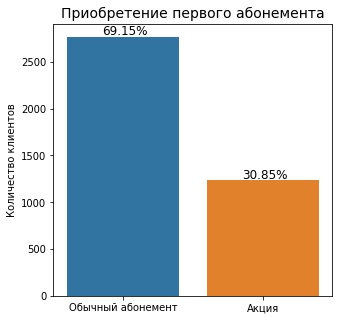

In [39]:
plt.figure(figsize=(5, 5))
fig = sns.barplot(x = "label", y = "n", data = pf) 
fig.set_title("Приобретение первого абонемента", fontsize = 14)
fig.set_ylabel("Количество клиентов", fontsize = 10)
fig.set_xlabel("")
show_percent(fig, 0.25, 20)

In [40]:
gym_churn['promo_friends'].describe()

count    4000.000000
mean        0.308500
std         0.461932
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: promo_friends, dtype: float64

Среднее значение - 0,31. Стандартное отклонение - 0,46.

Средние значения признака **promo_friends** тоже отличаются в пользу группы без оттока:

In [41]:
churn_clients['promo_friends'].mean().round(3)

0.184

In [42]:
nonchurn_clients['promo_friends'].mean().round(3)

0.354

In [43]:
pf_c = churn_clients.groupby(by = 'promo_friends').agg({'gender' : 'count'}).reset_index()\
                         .rename(columns = {'gender':'n'}).sort_values(by = 'n', ascending = False)
pf_nc = nonchurn_clients.groupby(by = 'promo_friends').agg({'gender' : 'count'}).reset_index()\
                         .rename(columns = {'gender':'n'}).sort_values(by = 'n', ascending = False)
pf_c['label'] = ['Обычный абонемент' if (i == 0) else 'Акция' for i in pf['promo_friends']]
pf_nc['label'] = ['Обычный абонемент' if (i == 0) else 'Акция' for i in pf['promo_friends']]

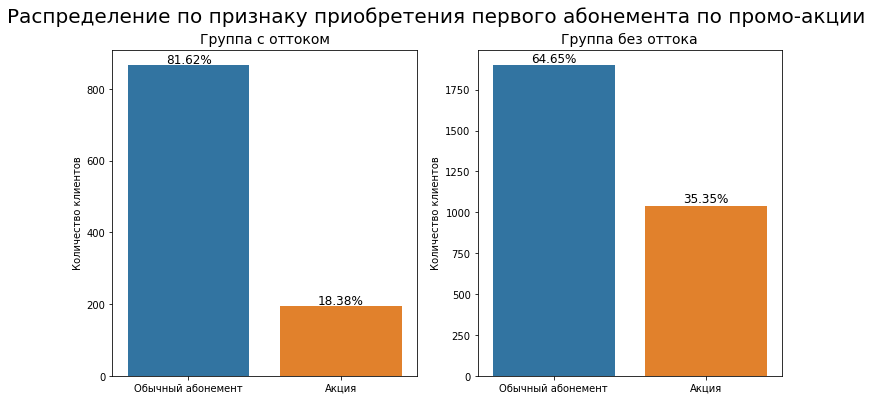

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

fig.suptitle('Распределение по признаку приобретения первого абонемента по промо-акции', fontsize = 20)

fig1 = sns.barplot(ax = axes[0], x = "label", y = "n", data = pf_c) 
fig1.set_title("Группа с оттоком", fontsize = 14)
fig1.set_ylabel("Количество клиентов", fontsize = 10)
fig1.set_xlabel("")
show_percent(fig1, 0.25, 5)

fig2 = sns.barplot(ax = axes[1], x = "label", y = "n", data = pf_nc) 
fig2.set_title("Группа без оттока", fontsize = 14)
fig2.set_ylabel("Количество клиентов", fontsize = 10)
fig2.set_xlabel("")
show_percent(fig2, 0.25, 20)

plt.show()

Доля клиентов, купивших первый абонемент по промо-акции, существенно больше в группе без оттока.

**phone - наличие контактного телефона**

In [45]:
gym_churn['phone'].value_counts()

1    3614
0     386
Name: phone, dtype: int64

90% клиентов оставили свой номер телефона фитнес-клубу.

In [46]:
pho = gym_churn.groupby(by = 'phone').agg({'gender' : 'count'}).reset_index()\
                         .rename(columns = {'gender':'n'}).sort_values(by = 'n', ascending = False)
pho['label'] = ['Нет' if (i == 0) else 'Есть' for i in pho['phone']]

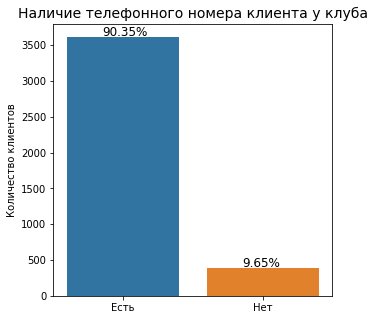

In [47]:
plt.figure(figsize=(5, 5))
fig = sns.barplot(x = "label", y = "n", data = pho) 
fig.set_title("Наличие телефонного номера клиента у клуба", fontsize = 14)
fig.set_ylabel("Количество клиентов", fontsize = 10)
fig.set_xlabel("")
show_percent(fig, 0.25, 20)

In [48]:
gym_churn['phone'].describe()

count    4000.000000
mean        0.903500
std         0.295313
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: phone, dtype: float64

Среднее значение - 0,90. Стандартное отклонение - 0,29.

Средние значения признака **phone** практически не отличаются в группах с оттоком и без оттока:

In [49]:
churn_clients['phone'].mean().round(3)

0.903

In [50]:
nonchurn_clients['phone'].mean().round(3)

0.904

In [51]:
pho_c = churn_clients.groupby(by = 'phone').agg({'gender' : 'count'}).reset_index()\
                         .rename(columns = {'gender':'n'}).sort_values(by = 'n', ascending = False)
pho_nc = nonchurn_clients.groupby(by = 'phone').agg({'gender' : 'count'}).reset_index()\
                         .rename(columns = {'gender':'n'}).sort_values(by = 'n', ascending = False)
pho_c['label'] = ['Нет' if (i == 0) else 'Есть' for i in pho_c['phone']]
pho_nc['label'] = ['Нет' if (i == 0) else 'Есть' for i in pho_nc['phone']]

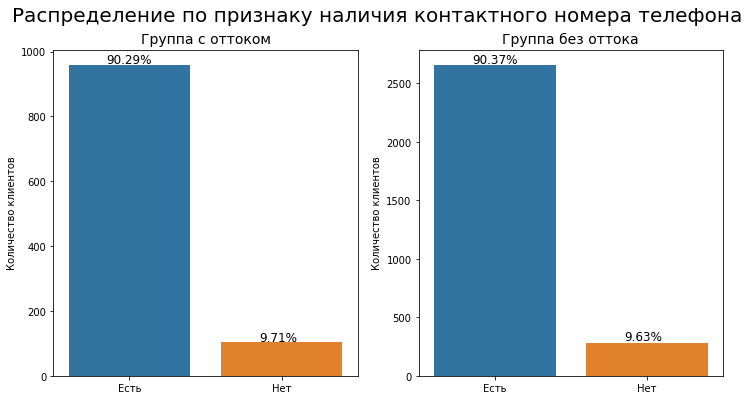

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

fig.suptitle('Распределение по признаку наличия контактного номера телефона', fontsize = 20)

fig1 = sns.barplot(ax = axes[0], x = "label", y = "n", data = pho_c) 
fig1.set_title("Группа с оттоком", fontsize = 14)
fig1.set_ylabel("Количество клиентов", fontsize = 10)
fig1.set_xlabel("")
show_percent(fig1, 0.25, 5)

fig2 = sns.barplot(ax = axes[1], x = "label", y = "n", data = pho_nc) 
fig2.set_title("Группа без оттока", fontsize = 14)
fig2.set_ylabel("Количество клиентов", fontsize = 10)
fig2.set_xlabel("")
show_percent(fig2, 0.25, 20)

plt.show()

Доля клиентов без номера телефона практически одинакова в обеих группах.

**contract_period - длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)**

In [53]:
gym_churn['contract_period'].value_counts()

1     2207
12     960
6      833
Name: contract_period, dtype: int64

Более половины клиентов пользуются абонементом на месяц, 24% - полугодовым, 21% - годовым. Трехмесячный абонемент никто не приобрел.

In [54]:
cp = gym_churn.groupby(by = 'contract_period').agg({'gender' : 'count'}).reset_index()\
                         .rename(columns = {'gender':'n'}).sort_values(by = 'n', ascending = False)

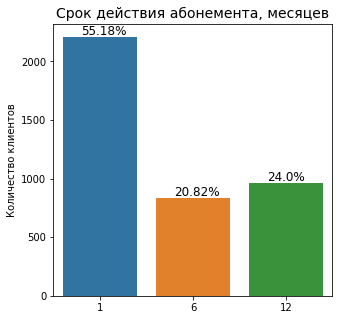

In [55]:
plt.figure(figsize=(5, 5))
fig = sns.barplot(x = "contract_period", y = "n", data = cp) 
fig.set_title("Срок действия абонемента, месяцев", fontsize = 14)
fig.set_ylabel("Количество клиентов", fontsize = 10)
fig.set_xlabel("")
show_percent(fig, 0.20, 20)

In [56]:
gym_churn['contract_period'].describe()

count    4000.000000
mean        4.681250
std         4.549706
min         1.000000
25%         1.000000
50%         1.000000
75%         6.000000
max        12.000000
Name: contract_period, dtype: float64

Среднее значение - 4,68. Стандартное отклонение - 4,55.

Средние значения признака **contract_period** значительно отличаются в группах с оттоком и без оттока в пользу последней:

In [57]:
churn_clients['contract_period'].mean().round(3)

1.729

In [58]:
nonchurn_clients['contract_period'].mean().round(3)

5.747

In [59]:
cp_c = churn_clients.groupby(by = 'contract_period').agg({'gender' : 'count'}).reset_index()\
                         .rename(columns = {'gender':'n'}).sort_values(by = 'n', ascending = False)
cp_nc = nonchurn_clients.groupby(by = 'contract_period').agg({'gender' : 'count'}).reset_index()\
                         .rename(columns = {'gender':'n'}).sort_values(by = 'n', ascending = False)

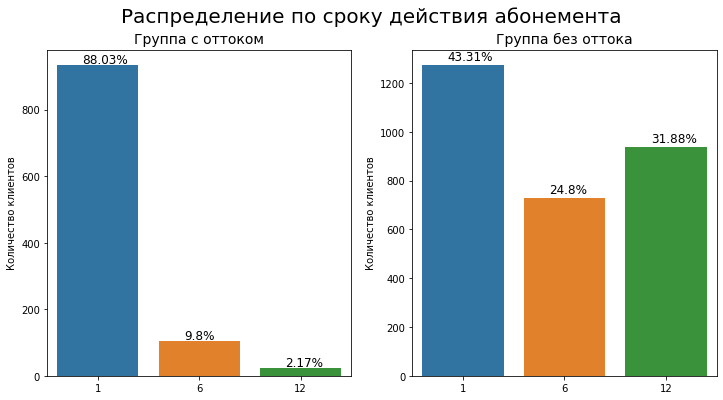

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

fig.suptitle('Распределение по сроку действия абонемента', fontsize = 20)

fig1 = sns.barplot(ax = axes[0], x = "contract_period", y = "n", data = cp_c) 
fig1.set_title("Группа с оттоком", fontsize = 14)
fig1.set_ylabel("Количество клиентов", fontsize = 10)
fig1.set_xlabel("")
show_percent(fig1, 0.25, 5)

fig2 = sns.barplot(ax = axes[1], x = "contract_period", y = "n", data = cp_nc) 
fig2.set_title("Группа без оттока", fontsize = 14)
fig2.set_ylabel("Количество клиентов", fontsize = 10)
fig2.set_xlabel("")
show_percent(fig2, 0.25, 20)

plt.show()

Почти все клиенты (88%) в группе оттока пользуются месячным абонементом. В группе без оттока картина совершенно иная: у 25% посетителей полугодовой абонемент, а у 32% - годовой.

**group_visits - факт посещения групповых занятий**

In [61]:
gym_churn['group_visits'].value_counts()

0    2351
1    1649
Name: group_visits, dtype: int64

59% клиентов не посещают групповые занятия.

In [62]:
gv = gym_churn.groupby(by = 'group_visits').agg({'gender' : 'count'}).reset_index()\
                         .rename(columns = {'gender':'n'}).sort_values(by = 'n', ascending = False)
gv['label'] = ['Нет' if (i == 0) else 'Да' for i in gv['group_visits']]

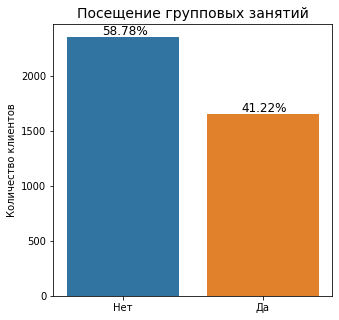

In [63]:
plt.figure(figsize=(5, 5))
fig = sns.barplot(x = "label", y = "n", data = gv) 
fig.set_title("Посещение групповых занятий", fontsize = 14)
fig.set_ylabel("Количество клиентов", fontsize = 10)
fig.set_xlabel("")
show_percent(fig, 0.25, 20)

In [64]:
gym_churn['group_visits'].describe()

count    4000.000000
mean        0.412250
std         0.492301
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: group_visits, dtype: float64

Среднее значение - 0,41. Стандартное отклонение - 0,49.

Среднее значение признака **group_visits** выше в группе без оттока:

In [65]:
churn_clients['group_visits'].mean().round(3)

0.269

In [66]:
nonchurn_clients['group_visits'].mean().round(3)

0.464

In [67]:
gv_c = churn_clients.groupby(by = 'group_visits').agg({'gender' : 'count'}).reset_index()\
                         .rename(columns = {'gender':'n'}).sort_values(by = 'n', ascending = False)
gv_nc = nonchurn_clients.groupby(by = 'group_visits').agg({'gender' : 'count'}).reset_index()\
                         .rename(columns = {'gender':'n'}).sort_values(by = 'n', ascending = False)
gv_c['label'] = ['Нет' if (i == 0) else 'Да' for i in gv_c['group_visits']]
gv_nc['label'] = ['Нет' if (i == 0) else 'Да' for i in gv_nc['group_visits']]

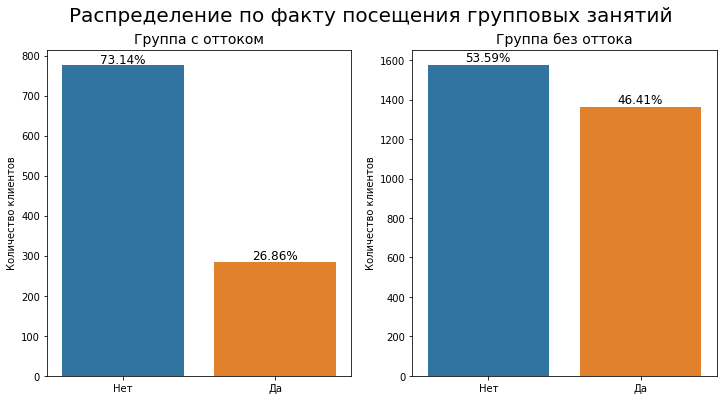

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

fig.suptitle('Распределение по факту посещения групповых занятий', fontsize = 20)

fig1 = sns.barplot(ax = axes[0], x = "label", y = "n", data = gv_c) 
fig1.set_title("Группа с оттоком", fontsize = 14)
fig1.set_ylabel("Количество клиентов", fontsize = 10)
fig1.set_xlabel("")
show_percent(fig1, 0.25, 5)

fig2 = sns.barplot(ax = axes[1], x = "label", y = "n", data = gv_nc) 
fig2.set_title("Группа без оттока", fontsize = 14)
fig2.set_ylabel("Количество клиентов", fontsize = 10)
fig2.set_xlabel("")
show_percent(fig2, 0.25, 20)

plt.show()

Доля клиентов, посещающих групповые занятия, выше в группе без оттока.

**age - возраст**

In [69]:
gym_churn['age'].describe()

count    4000.000000
mean       29.184250
std         3.258367
min        18.000000
25%        27.000000
50%        29.000000
75%        31.000000
max        41.000000
Name: age, dtype: float64

Самому молодому клиенту 18 лет, а самому возрастному - 41 год. Средний возраст посетиелей - 29 лет, стандартное отклонение - 3,2 года.

Построим график распределения:

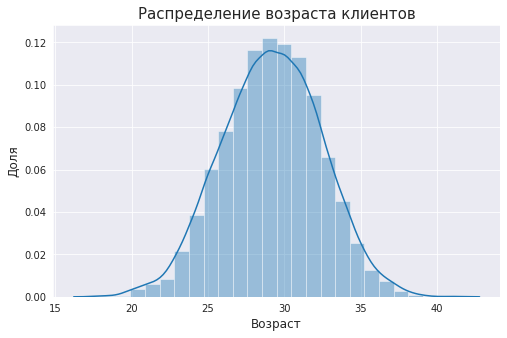

In [70]:
plt.figure(figsize=(8, 5))
sns.set_style("darkgrid")
fig = sns.distplot(gym_churn['age'], kde = True, bins = gym_churn['age'].max() - gym_churn['age'].min() + 1)
fig.set_title("Распределение возраста клиентов", fontsize = 15)
fig.set_xlabel("Возраст", fontsize = 12)
fig.set_ylabel("Доля", fontsize = 12)

plt.show()

Распределение соответствует нормальному.

Среднее значение признака **age** выше в группе без оттока:

In [71]:
churn_clients['age'].mean().round(3)

26.99

In [72]:
nonchurn_clients['age'].mean().round(3)

29.977

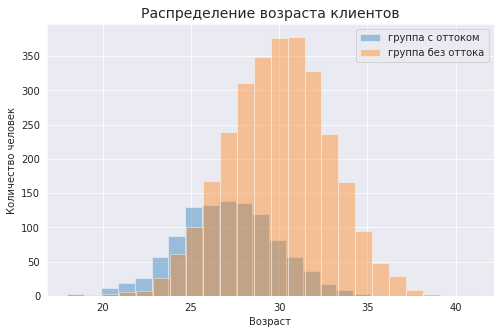

In [73]:
plt.figure(figsize=(8, 5))
fig1 = sns.distplot(churn_clients['age'], kde = False, \
                    bins = churn_clients['age'].max() - churn_clients['age'].min() + 1, label = 'группа с оттоком') 
fig2 = sns.distplot(nonchurn_clients['age'], kde = False, \
                    bins = nonchurn_clients['age'].max() - nonchurn_clients['age'].min() + 1, label = 'группа без оттока')  
fig2.set_title("Распределение возраста клиентов", fontsize = 14)
fig2.set_ylabel("Количество человек", fontsize = 10)
fig2.set_xlabel("Возраст")
plt.legend()
plt.show()

Как видно, высота распределений отличается за счет того, что в группах разное количество человек; также они оказались сдвинуты относительно друг друга. В группе, где нет оттока, средний возраст клиентов на три года выше.

**avg_additional_charges_total - суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон**

In [74]:
gym_churn['avg_additional_charges_total'].describe()

count    4000.000000
mean      146.943728
std        96.355602
min         0.148205
25%        68.868830
50%       136.220159
75%       210.949625
max       552.590740
Name: avg_additional_charges_total, dtype: float64

Минимальная выручка по клиенту от непрофильных услуг фитнес-центра составила 0,15 у.е, а макимальная - 552,6 у.е. Среднее значение - 146,9 у.е, медианное - 136,2 у.е. Стандартное отклонение - 96,35 у.е.

Построим график распределения:

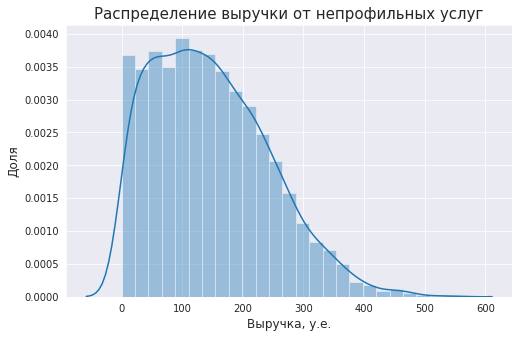

In [75]:
plt.figure(figsize=(8, 5))
sns.set_style("darkgrid")
fig = sns.distplot(gym_churn['avg_additional_charges_total'], kde = True, bins = 25)
fig.set_title("Распределение выручки от непрофильных услуг", fontsize = 15)
fig.set_xlabel("Выручка, у.е.", fontsize = 12)
fig.set_ylabel("Доля", fontsize = 12)

plt.show()

Распределение отлично от нормального.

Среднее значение признака **avg_additional_charges_total** выше в группе без оттока:

In [76]:
churn_clients['avg_additional_charges_total'].mean().round(3)

115.083

In [77]:
nonchurn_clients['avg_additional_charges_total'].mean().round(3)

158.446

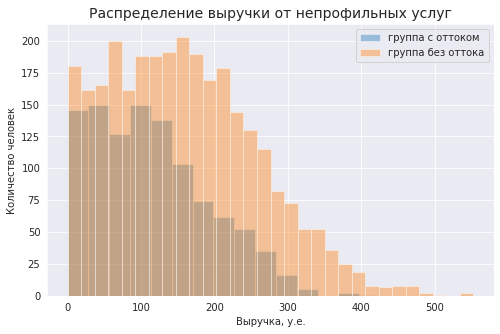

In [78]:
plt.figure(figsize=(8, 5))
fig1 = sns.distplot(churn_clients['avg_additional_charges_total'], kde = False, \
                    bins = 15, label = 'группа с оттоком') 
fig2 = sns.distplot(nonchurn_clients['avg_additional_charges_total'], kde = False, \
                    bins = 30, label = 'группа без оттока')  
fig2.set_title("Распределение выручки от непрофильных услуг", fontsize = 14)
fig2.set_ylabel("Количество человек", fontsize = 10)
fig2.set_xlabel("Выручка, у.е.")
plt.legend()
plt.show()

Распределение в группе без оттока занимает большую часть площади графика, поскольку численность этой группы выше. Также в ней выше число клиентов с большей выручкой. В группе с оттоком основная часть посетителей сконцентрирована в левой части графика с меньшей доходностью.

**month_to_end_contract - срок до окончания текущего действующего абонемента (в месяцах)**

In [79]:
gym_churn['month_to_end_contract'].value_counts()

1.0     2207
6.0      645
12.0     524
11.0     181
5.0      130
10.0      82
9.0       73
4.0       58
8.0       38
7.0       25
3.0       23
2.0       14
Name: month_to_end_contract, dtype: int64

Все значения целые, поэтому можно поменять тип переменной:

In [80]:
gym_churn['month_to_end_contract'] = gym_churn['month_to_end_contract'].astype('int64')
churn_clients['month_to_end_contract'] = churn_clients['month_to_end_contract'].astype('int64')
nonchurn_clients['month_to_end_contract'] = nonchurn_clients['month_to_end_contract'].astype('int64')

In [81]:
gym_churn['month_to_end_contract'].describe()

count    4000.000000
mean        4.322750
std         4.191297
min         1.000000
25%         1.000000
50%         1.000000
75%         6.000000
max        12.000000
Name: month_to_end_contract, dtype: float64

В среднем до окончания действия абонемента у клиентов остается 4,3 месяца. При этом медианное значение - 1 месяц, поскольку, как мы выяснили ранее, более чем у половины посетителей абонемент сроком всего на месяц.

In [82]:
mon = gym_churn.groupby(by = 'month_to_end_contract').agg({'gender' : 'count'}).reset_index()\
                         .rename(columns = {'gender':'n'}).sort_values(by = 'n', ascending = False)

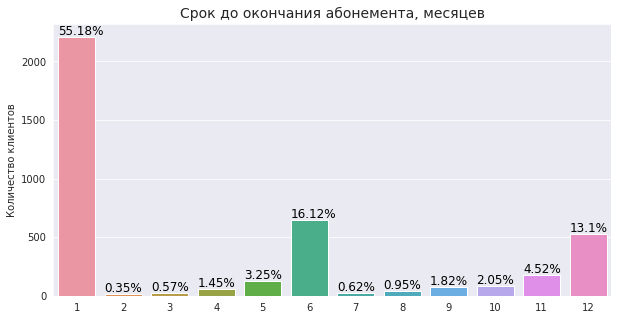

In [83]:
plt.figure(figsize=(10, 5))
fig = sns.barplot(x = "month_to_end_contract", y = "n", data = mon) 
fig.set_title("Срок до окончания абонемента, месяцев", fontsize = 14)
fig.set_ylabel("Количество клиентов", fontsize = 10)
fig.set_xlabel("")
show_percent(fig, 0, 20)

Средние значения признака **month_to_end_contract** ожидаемо отличаются в группах с оттоком и без оттока в пользу последней, поскольку переменная коррелирует с рассмотренным выше признаком **contract_period** - сроком абонемента. В группе оттока владельцев долгосрочных абонементов почти не было.

In [84]:
churn_clients['month_to_end_contract'].mean().round(3)

1.663

In [85]:
nonchurn_clients['month_to_end_contract'].mean().round(3)

5.283

In [86]:
mon_c = churn_clients.groupby(by = 'month_to_end_contract').agg({'gender' : 'count'}).reset_index()\
                         .rename(columns = {'gender':'n'}).sort_values(by = 'n', ascending = False)
mon_nc = nonchurn_clients.groupby(by = 'month_to_end_contract').agg({'gender' : 'count'}).reset_index()\
                         .rename(columns = {'gender':'n'}).sort_values(by = 'n', ascending = False)

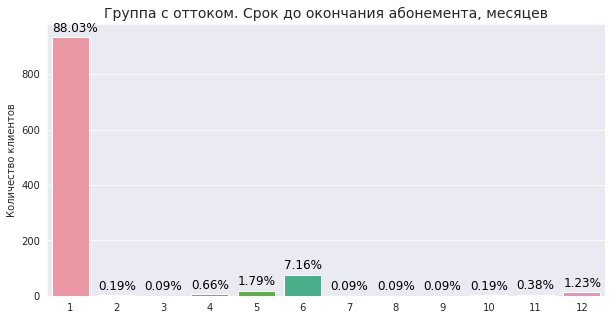

In [87]:
plt.figure(figsize=(10, 5))
fig = sns.barplot(x = "month_to_end_contract", y = "n", data = mon_c) 
fig.set_title("Группа с оттоком. Срок до окончания абонемента, месяцев", fontsize = 14)
fig.set_ylabel("Количество клиентов", fontsize = 10)
fig.set_xlabel("")
show_percent(fig, 0, 20)
plt.show()

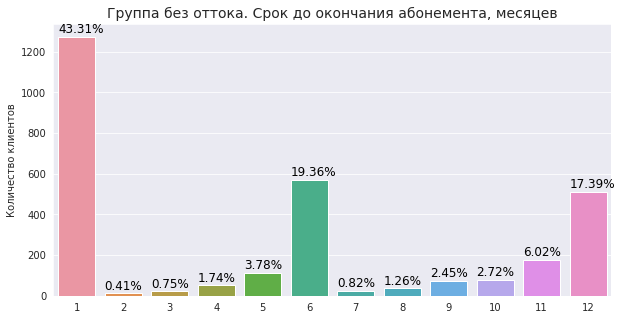

In [88]:
plt.figure(figsize=(10, 5))
fig = sns.barplot(x = "month_to_end_contract", y = "n", data = mon_nc) 
fig.set_title("Группа без оттока. Срок до окончания абонемента, месяцев", fontsize = 14)
fig.set_ylabel("Количество клиентов", fontsize = 10)
fig.set_xlabel("")
show_percent(fig, 0, 20)
plt.show()

Ожидаемо в группе оттока 88% абонементов истекает через месяц. В группе без оттока доля таких абонементов всего 43%. 19% заканчивается через полгода, 17% - через год.

**lifetime - время с момента первого обращения в фитнес-центр (в месяцах)**

In [89]:
gym_churn['lifetime'].describe()

count    4000.000000
mean        3.724750
std         3.749267
min         0.000000
25%         1.000000
50%         3.000000
75%         5.000000
max        31.000000
Name: lifetime, dtype: float64

Минимальное время с момента обращения клиента в фитнес-центр лежит в пределах от 0 до 31 месяца. Среднее значение - 3,72 мес., медиана - 3 мес., стандартное отклонение - 3,7.

Построим график распределения:

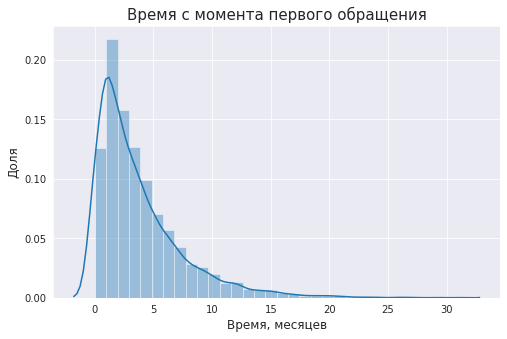

In [90]:
plt.figure(figsize=(8, 5))
sns.set_style("darkgrid")
fig = sns.distplot(gym_churn['lifetime'], kde = True, \
                   bins = gym_churn['lifetime'].max() - gym_churn['lifetime'].min() + 1)
fig.set_title("Время с момента первого обращения", fontsize = 15)
fig.set_xlabel("Время, месяцев", fontsize = 12)
fig.set_ylabel("Доля", fontsize = 12)

plt.show()

Распределение отлично от нормального.

Среднее значение признака **lifetime** значительно выше в группе без оттока:

In [91]:
churn_clients['lifetime'].mean().round(3)

0.991

In [92]:
nonchurn_clients['lifetime'].mean().round(3)

4.712

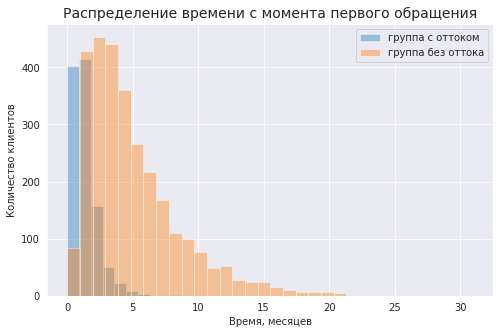

In [93]:
plt.figure(figsize=(8, 5))
fig1 = sns.distplot(churn_clients['lifetime'], kde = False, \
                    bins = churn_clients['lifetime'].max() - churn_clients['lifetime'].min() + 1, label = 'группа с оттоком') 
fig2 = sns.distplot(nonchurn_clients['lifetime'], kde = False, \
                    bins = nonchurn_clients['lifetime'].max() - nonchurn_clients['lifetime'].min() + 1, label = 'группа без оттока')  
fig2.set_title("Распределение времени с момента первого обращения", fontsize = 14)
fig2.set_ylabel("Количество клиентов", fontsize = 10)
fig2.set_xlabel("Время, месяцев")
plt.legend()
plt.show()

Клиенты со значением признака 0 в основном находятся в группе с оттоком. В целом "хвост" распределения группы без оттока гораздо длиннее, т.е. в нее попали клиенты, которых можно отнести к категории постоянных.

**avg_class_frequency_total - средняя частота посещений в неделю за все время с начала действия абонемента**

In [94]:
gym_churn['avg_class_frequency_total'].describe()

count    4000.000000
mean        1.879020
std         0.972245
min         0.000000
25%         1.180875
50%         1.832768
75%         2.536078
max         6.023668
Name: avg_class_frequency_total, dtype: float64

Минимальная средняя частота посещений в неделю - 0 (те, кто купил абонемент и по каким-то причинам не пользовался им), максимальная - 6. Среднее значение - 1,87 раз, медиана - 1,83 раза, стандартное отклонение - 0,97.

Построим график распределения:

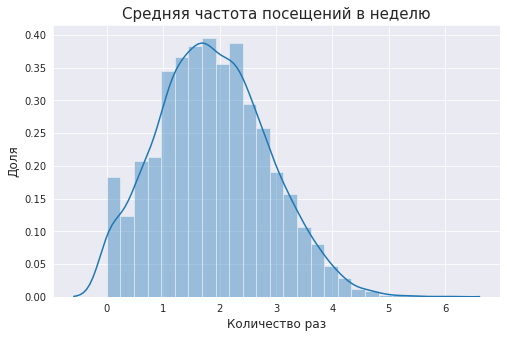

In [95]:
plt.figure(figsize=(8, 5))
sns.set_style("darkgrid")
fig = sns.distplot(gym_churn['avg_class_frequency_total'], kde = True, \
                   bins = 25)
fig.set_title("Средняя частота посещений в неделю", fontsize = 15)
fig.set_xlabel("Количество раз", fontsize = 12)
fig.set_ylabel("Доля", fontsize = 12)

plt.show()

Распределение визуально напоминает нормальное.

В очередной раз среднее значение признака **avg_class_frequency_total** выше в группе без оттока:

In [96]:
churn_clients['avg_class_frequency_total'].mean().round(3)

1.475

In [97]:
nonchurn_clients['avg_class_frequency_total'].mean().round(3)

2.025

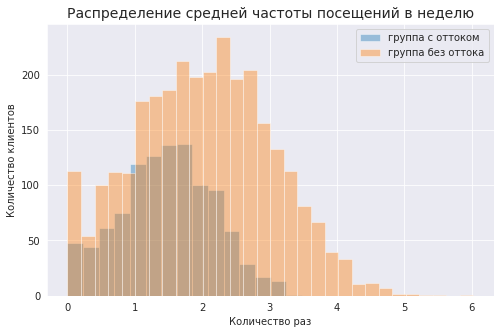

In [98]:
plt.figure(figsize=(8, 5))
fig1 = sns.distplot(churn_clients['avg_class_frequency_total'], kde = False, \
                    bins = 15, label = 'группа с оттоком') 
fig2 = sns.distplot(nonchurn_clients['avg_class_frequency_total'], kde = False, \
                    bins = 30, label = 'группа без оттока')  
fig2.set_title("Распределение cредней частоты посещений в неделю", fontsize = 14)
fig2.set_ylabel("Количество клиентов", fontsize = 10)
fig2.set_xlabel("Количество раз")
plt.legend()
plt.show()

Клиенты из группы оттока в среднем ходят в клуб не более трех раз в неделю, в то время как из группы без оттока - до 6 раз. Среднее по группе с оттоком - 1,47, а по группе без оттока - 2,02.

**avg_class_frequency_current_month - средняя частота посещений в неделю за предыдущий месяц**

In [99]:
gym_churn['avg_class_frequency_current_month'].describe()

count    4000.000000
mean        1.767052
std         1.052906
min         0.000000
25%         0.963003
50%         1.719574
75%         2.510336
max         6.146783
Name: avg_class_frequency_current_month, dtype: float64

Минимальная средняя частота посещений в неделю за предыдущий месяц - 0, максимальная - 6,14. Среднее значение - 1,76 раз, медиана - 1,71 раза, стандартное отклонение - 1,05.

Построим график распределения:

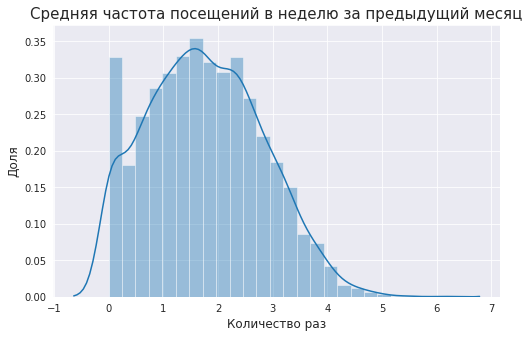

In [100]:
plt.figure(figsize=(8, 5))
sns.set_style("darkgrid")
fig = sns.distplot(gym_churn['avg_class_frequency_current_month'], kde = True, \
                   bins = 25)
fig.set_title("Средняя частота посещений в неделю за предыдущий месяц", fontsize = 15)
fig.set_xlabel("Количество раз", fontsize = 12)
fig.set_ylabel("Доля", fontsize = 12)

plt.show()

Распределение напоминает нормальное за исключением пика в крайней части графика слева.

Среднее значение признака **avg_class_frequency_current_month** выше в группе без оттока:

In [101]:
churn_clients['avg_class_frequency_current_month'].mean().round(3)

1.045

In [102]:
nonchurn_clients['avg_class_frequency_current_month'].mean().round(3)

2.028

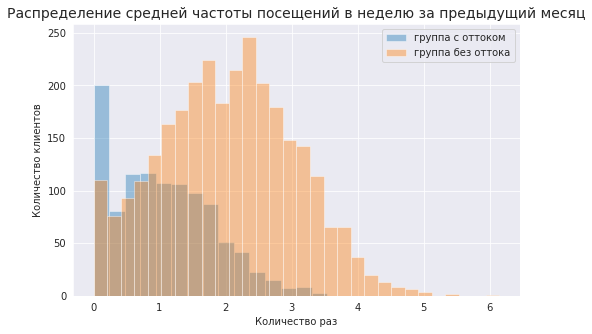

In [103]:
plt.figure(figsize=(8, 5))
fig1 = sns.distplot(churn_clients['avg_class_frequency_current_month'], kde = False, \
                    bins = 15, label = 'группа с оттоком') 
fig2 = sns.distplot(nonchurn_clients['avg_class_frequency_current_month'], kde = False, \
                    bins = 30, label = 'группа без оттока')  
fig2.set_title("Распределение cредней частоты посещений в неделю за предыдущий месяц", fontsize = 14)
fig2.set_ylabel("Количество клиентов", fontsize = 10)
fig2.set_xlabel("Количество раз")
plt.legend()
plt.show()

Клиенты из группы оттока в среднем в прошедшем месяце ходили в клуб не более трех раз в неделю, в то время как из группы без оттока - до 6 раз. Среднее по группе с оттоком - 1,04, а по группе без оттока - 2,02.

Наконец, выведем таблицу со средними значениями и стандартными отклонениями всех признаков, а также таблицу со средними значениями признаков в группах с оттоком и без.

In [137]:
gym_churn.describe().loc[['mean','std']]

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521


In [145]:
print('Группа с оттоком:')
churn_clients.describe().loc[['mean']]

Группа с оттоком:


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
mean,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546,1.0


In [147]:
print('Группа без оттока:')
nonchurn_clients.describe().loc[['mean']]

Группа без оттока:


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
mean,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882,0.0


#### Матрица корреляции

Построим матрицу корреляции признаков и целевой переменной:

In [105]:
cm = gym_churn.corr()

In [106]:
features = ['пол', 'расположение', 'партнер клуба', 'промо-акция', 'телефон', 'срок абонемента', 'групповые занятия',\
            'возраст', 'выручка от других услуг', 'срок до окончания', 'общий срок посещения', 'частота посещений',\
            'частота посещений в последний месяц', 'отток']

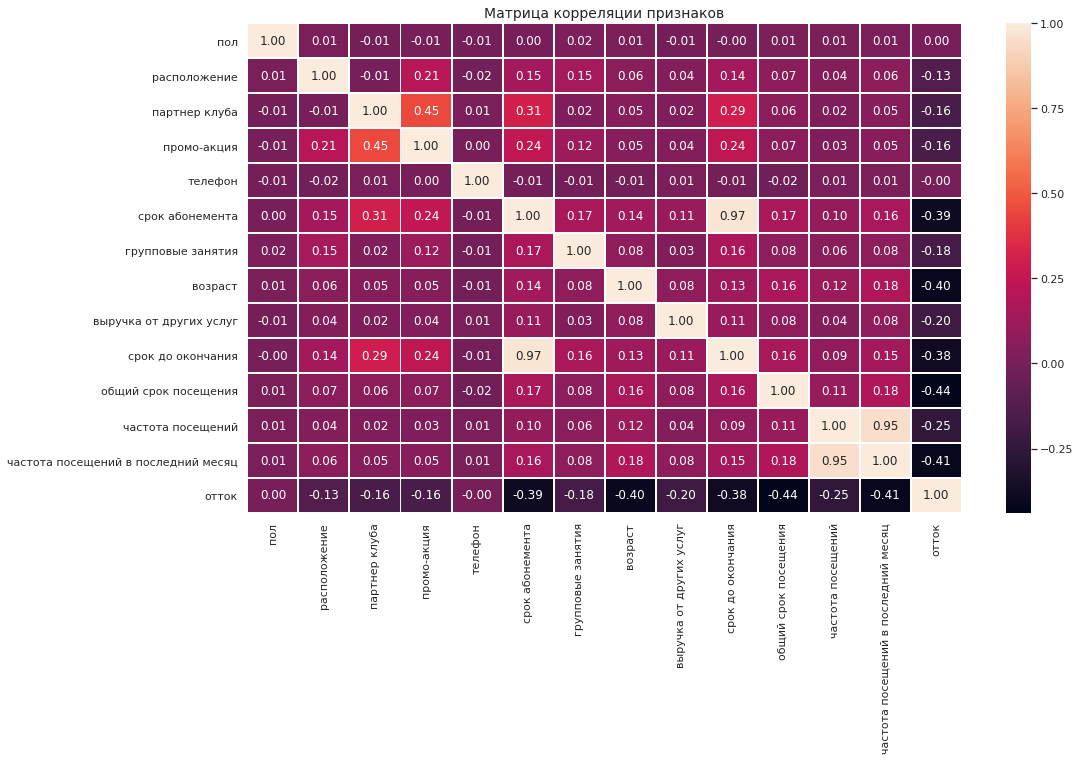

In [107]:
sns.set(style = 'white')
plt.figure(figsize = (16, 9))
plt.title('Матрица корреляции признаков', fontsize = 14)
ax = sns.heatmap(cm, annot = True, linewidths = 1, linecolor = 'white', fmt = '.2f', xticklabels = features, yticklabels = features)
plt.show()

Матрица корреляции подтверждает предварительные выводы, полученные в ходе анализа каждого из признаков:
- практически максимальная корреляция признаков *длительности текущего абонемента* и *срока до окончания текущего абонемента* (97%), а также *средней частоты посещений в неделю за все время* и *средней частоты посещений в неделю за предыдущий месяц* (95%). Учитывая это обстоятельство, в дальнейшем анализе оставим по одному из указанных признаков.
- нулевая корреляция *оттока* с признаками *пол* и *наличие контактного телефона*; также уберем их из датасета;
- отрицательная корреляция *оттока* в той или иной степени с каждым из остальных признаков. Наиболее сильная - со сроком абонемента, возрастом, сроком общего посещения, частотой посещений. 

In [108]:
gym_churn_new = gym_churn.drop(['month_to_end_contract', 'avg_class_frequency_current_month', 'gender', 'phone'], axis = 1)
gym_churn_new.head()

,near_location,partner,promo_friends,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_total,churn
0,1,1,1,6,1,29,14.227470,3,0.020398,0
1,1,0,0,12,1,31,113.202938,7,1.922936,0
2,1,1,0,1,0,28,129.448479,2,1.859098,0
3,1,1,1,12,1,33,62.669863,2,3.205633,0
4,1,1,1,1,0,26,198.362265,3,1.113884,0


#### Вывод

В ходе предварительного анализа было вывлено следующее:
- пропусков и дубликатов в исходном датасете нет;
- признаки *длительность текущего абонемента* и *срок до окончания текущего абонемента* взаимосвязаны с коэффициентом корреляции 0,97. Из датасета удален столбец **month_to_end_contract**.
- признаки *средняя частота посещений в неделю за все время* и *средняя частота посещений в неделю за предыдущий месяц* взаимосвязаны с коэффициентом корреляции 0,95. Удален столбец **avg_class_frequency_current_month**.
- отсутствие взаимосвязи признаков *пол* и *наличие контактного телефона* с целевой переменной *оттока*. Столбцы **gender** и **phone** удалены датасета.
- отрицательная корреляция *оттока* в той или иной степени с остальными признаками. 

# Построение модели прогнозирования оттока клиентов

Целевой признак — факт оттока клиента в следующем месяце (два класса: "1" - клиент в оттоке, "0" - клиент не в оттоке). Поскольку мы владеем информацией об оттоке посетителей и будем обучать модель на таких данных, то подходящая модель - модель бинарной классификации. 

Разделим данные на признаки и целевую переменную:

In [109]:
X = gym_churn_new.drop(columns = ['churn'])
y = gym_churn_new['churn']

Разделим модель на обучающую и валидационную выборку:

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

Проведем стандартизацию данных:

In [111]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

Зададим алгоритм логистической регрессии и обучим модель:

In [112]:
lr_model = LogisticRegression(random_state = 0)
lr_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Воспользуемся обученной моделью, чтобы сделать прогноз на валидационной выборке:

In [113]:
lr_probabilities = lr_model.predict_proba(X_test)[:, 1]

Бинарный прогноз:

In [114]:
lr_predictions = lr_model.predict(X_test)

Посчитаем метрики:

In [115]:
print('Метрики для модели логистической регрессии:')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, lr_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, lr_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, lr_predictions)))

Метрики для модели логистической регрессии:
Accuracy: 0.88
Precision: 0.75
Recall: 0.78


Теперь зададим алгоритм случайного леса и обучим модель:

In [116]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf_model.fit(X_train_st, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

Воспользуемся обученной моделью, чтобы сделать прогноз на валидационной выборке:

In [117]:
rf_predictions = rf_model.predict(X_test_st) 
rf_probabilities = rf_model.predict_proba(X_test_st)[:, 1] 

Посчитаем метрики:

In [118]:
print('Метрики для модели случайного леса:')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, rf_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, rf_predictions)))

Метрики для модели случайного леса:
Accuracy: 0.89
Precision: 0.78
Recall: 0.77


#### Вывод

Исходная выборка была разделена в пропорции 80:20 на тестовую и валидационную. Для построения прогноза использовалось две модели - логистической регрессии и случайного леса. На валидационной выборке модели показали примерно одинаковый результат:
- Доля правильных ответов (accuracy) - 0.88 у логистической регрессии и 0.89 у случайного леса;
- Точность (precision) - 0.75 у логистической регрессии и 0.78 у случайного леса;
- Полнота (recall) - 0.78 у логистической регрессии и 0.77 у случайного леса.

Между метриками нет существенного различия. Случайный лес дает чуть лучшие результаты в части точности.

# Кластеризация клиентов

Проведем кластеризацию клиентов. Для этого будем использовать матрицу признаков X (без целевой переменой оттока). Стандартизируем данные:

In [119]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

Построим матрицу расстояний на стандартизованной матрице признаков и выведем дендрограмму:

In [120]:
linked = linkage(X_sc, method = 'ward') 

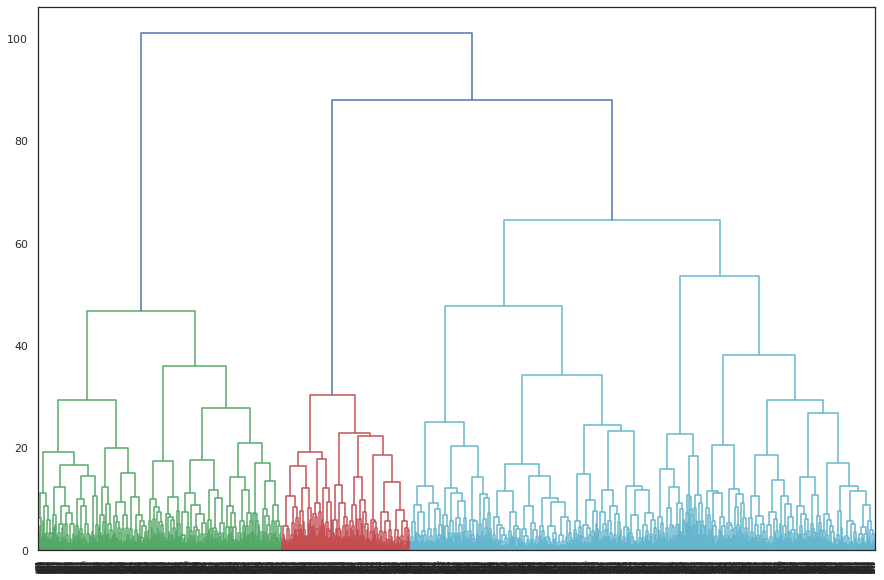

In [121]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show()

На дендрограмме выделяются 4 кластера (по одному зеленого и красного цвета, а также два голубого). Исходя из поставленного условия, будем далее предполагать, что число кластеров равно 5.

Спрогнозируем кластеры на основании алгоритма K-means:

In [122]:
km = KMeans(n_clusters = 5, random_state = 0)
labels = km.fit_predict(X_sc)
X['cluster_km'] = labels

Выведем статистику по средним значениям признаков по кластеру:

In [123]:
display(X.groupby('cluster_km').mean())

,near_location,partner,promo_friends,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_total
cluster_km,,,,,,,,,
0,1.000000,0.246776,0.058469,2.950129,0.000000,28.584695,140.112487,2.444540,1.764249
1,0.996113,0.960155,0.941691,7.448980,0.479106,29.574344,154.498117,3.634597,1.931320
2,1.000000,0.244014,0.084379,4.461802,1.000000,29.458381,146.463808,2.850627,1.920231
3,0.000000,0.490000,0.071667,2.945000,0.228333,28.681667,136.832314,2.783333,1.765080
4,0.954683,0.495468,0.241692,5.888218,0.429003,30.262840,167.061566,12.525680,2.217033


Первый кластер (с индексом 0) отличается от прочих нулевым средним значением признака *групповые посещения*, минимальным средним значением признака *промо-акция* и самой низкй средней выручкой от прочих услуг.

Второй - самым большим средним значением признаков *промо-акция* и *срок абонемента*. 

Третий - максимальным средним значением признака *групповые посещения*.

Четвертый - нулевым значением признака *расположение рядом с работой или домом* и близким к нулевому *промо-акция*. Также средняя выручка от прочих услуг в этой группе минимальная.

Пятый - самой крупной средней *выручкой от прочих прдаж* и самым длинным средним *сроком с момента первого обращения в фитнес-центр*. 

In [124]:
X.head()

,near_location,partner,promo_friends,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_total,cluster_km
0,1,1,1,6,1,29,14.227470,3,0.020398,1
1,1,0,0,12,1,31,113.202938,7,1.922936,2
2,1,1,0,1,0,28,129.448479,2,1.859098,0
3,1,1,1,12,1,33,62.669863,2,3.205633,1
4,1,1,1,1,0,26,198.362265,3,1.113884,1


Выведем для каждого кластера распределения признаков:

In [125]:
X_cols = X.columns.values.tolist() 
del X_cols[-1]
print(X_cols)

['near_location', 'partner', 'promo_friends', 'contract_period', 'group_visits', 'age', 'avg_additional_charges_total', 'lifetime', 'avg_class_frequency_total']


In [126]:
X_cols_rus = ['расположение', 'партнер клуба', 'промо-акция', 'срок абонемента', 'групповые занятия',\
            'возраст', 'выручка от других услуг', 'общий срок посещения', 'частота посещений']

Кластер 1


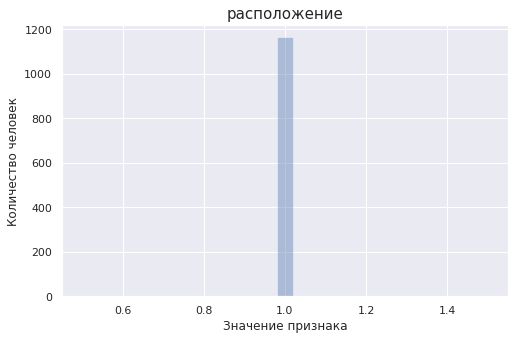

Кластер 2


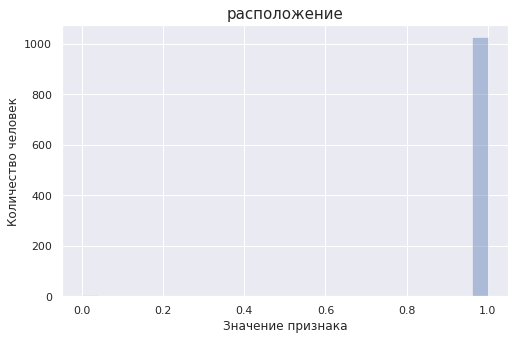

Кластер 3


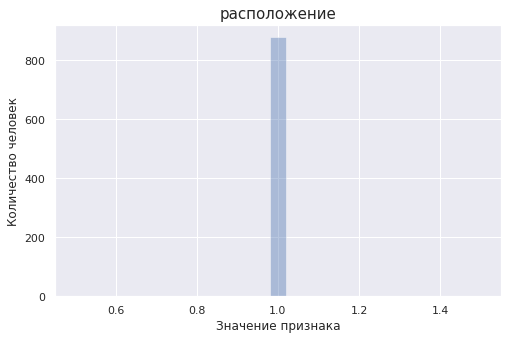

Кластер 4


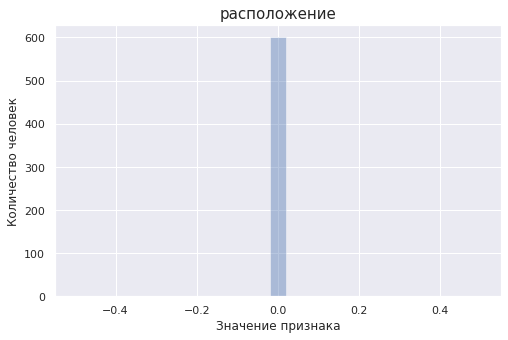

Кластер 5


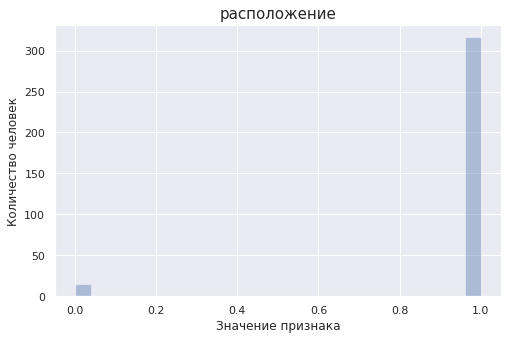

Кластер 1


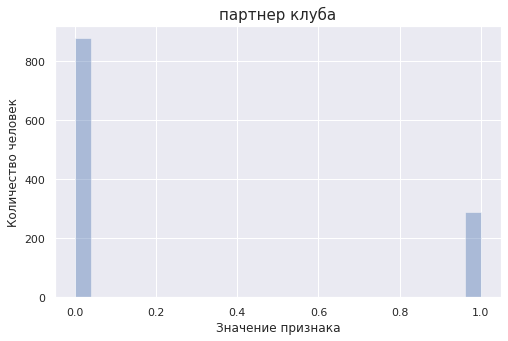

Кластер 2


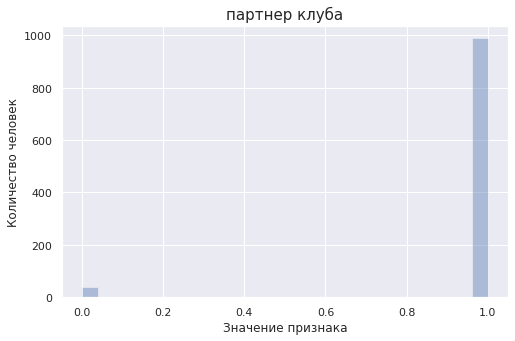

Кластер 3


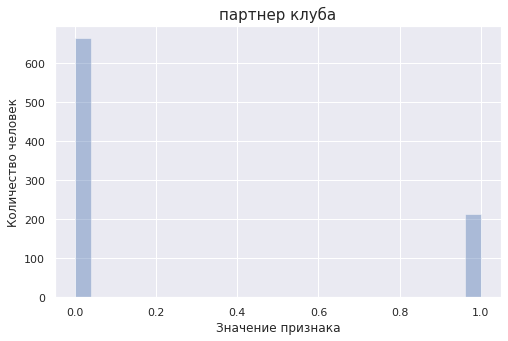

Кластер 4


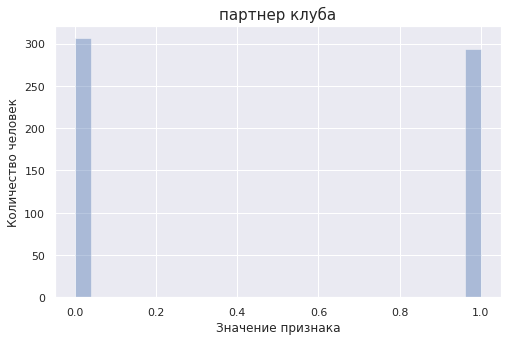

Кластер 5


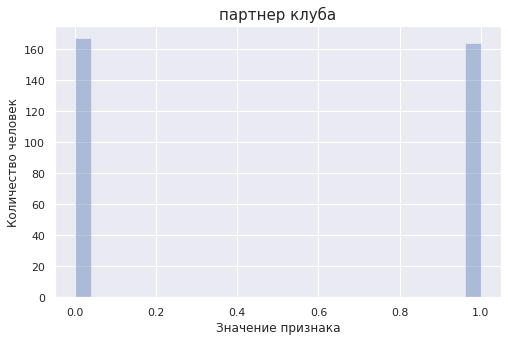

Кластер 1


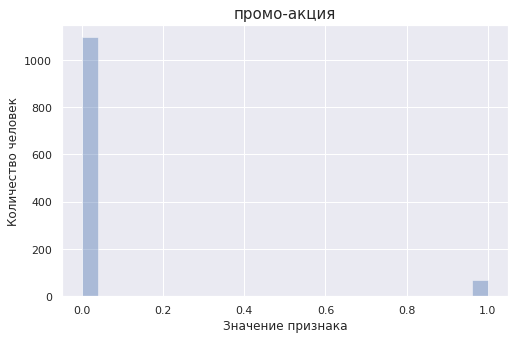

Кластер 2


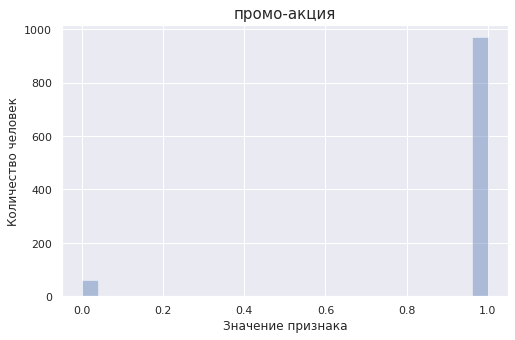

Кластер 3


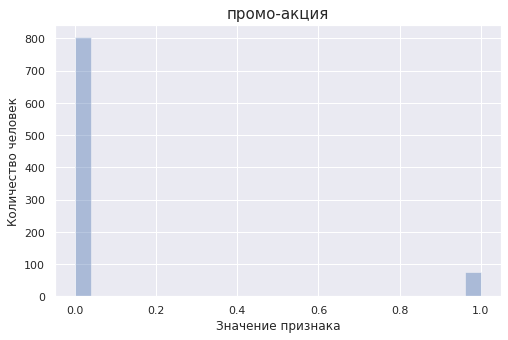

Кластер 4


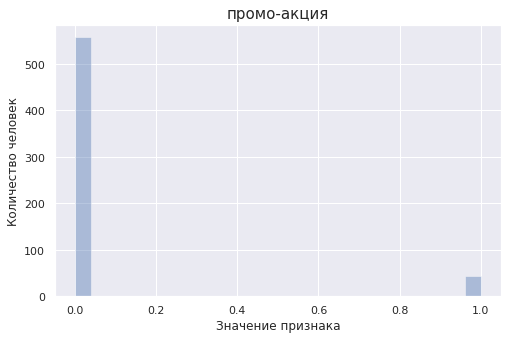

Кластер 5


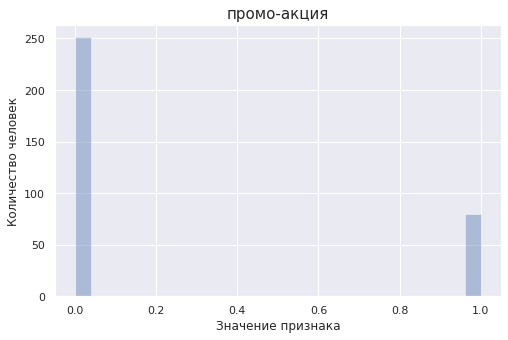

Кластер 1


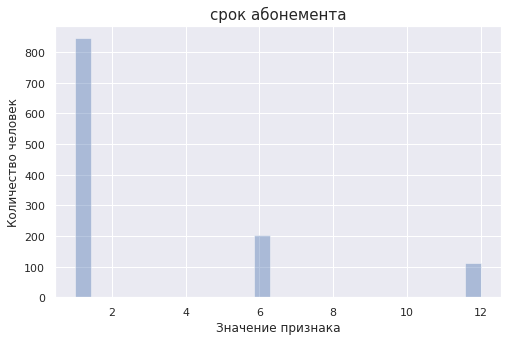

Кластер 2


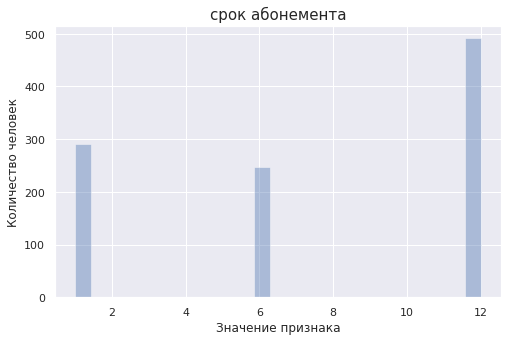

Кластер 3


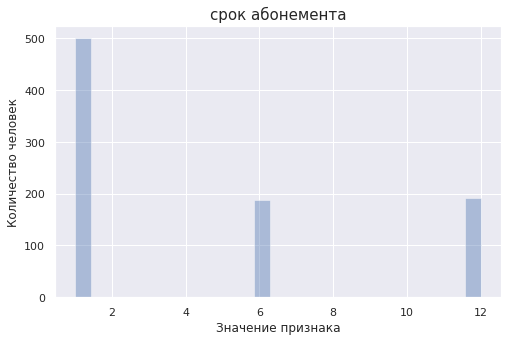

Кластер 4


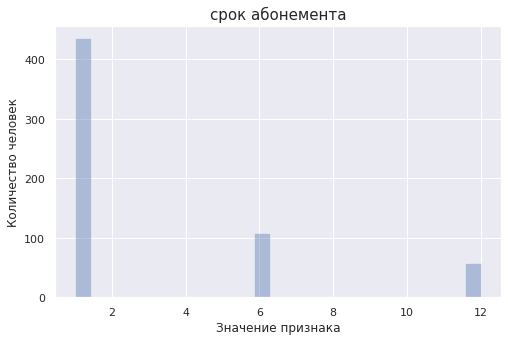

Кластер 5


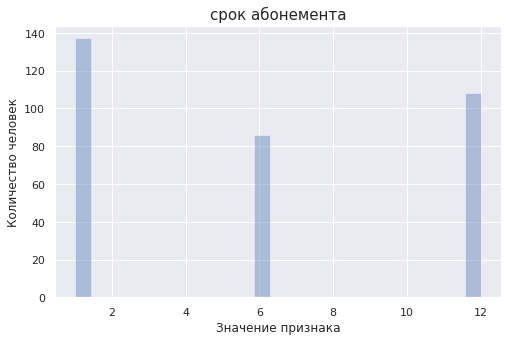

Кластер 1


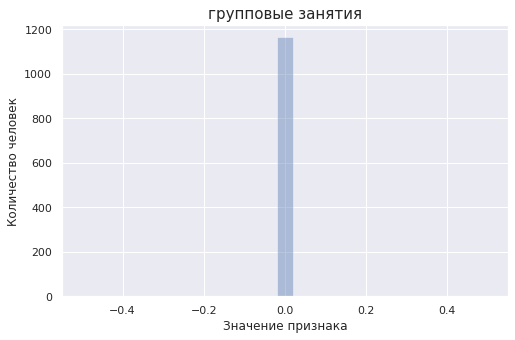

Кластер 2


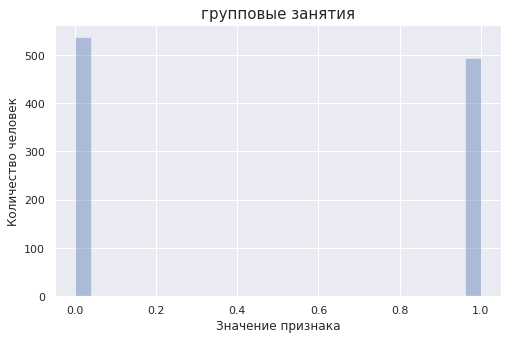

Кластер 3


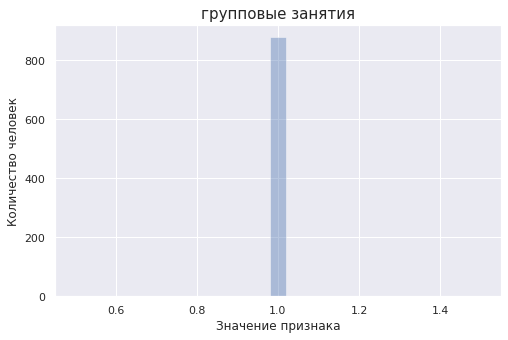

Кластер 4


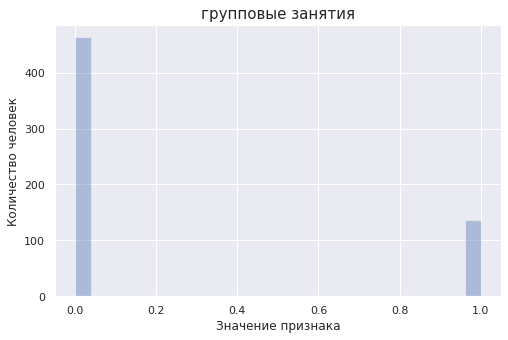

Кластер 5


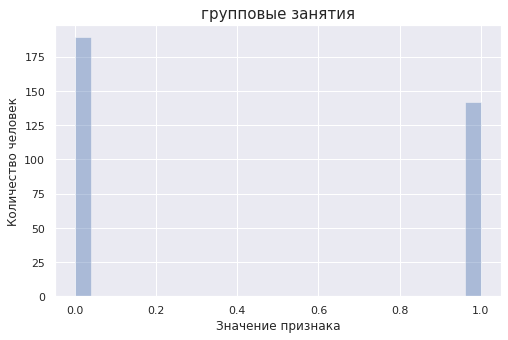

Кластер 1


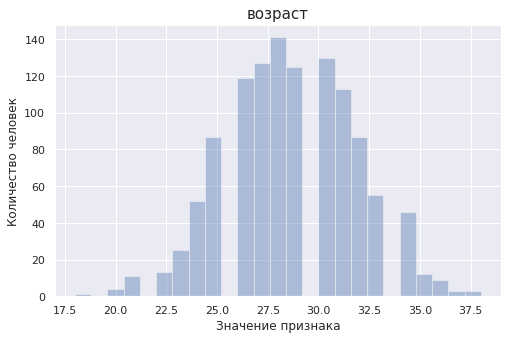

Кластер 2


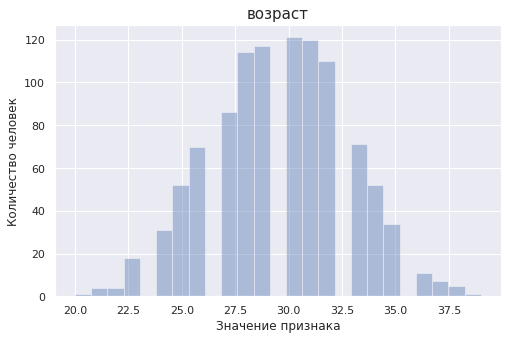

Кластер 3


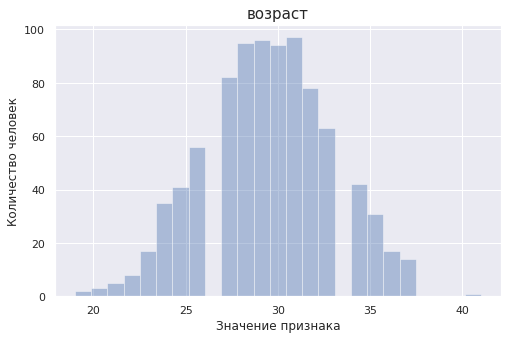

Кластер 4


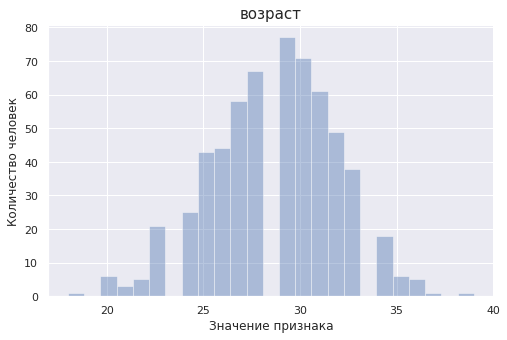

Кластер 5


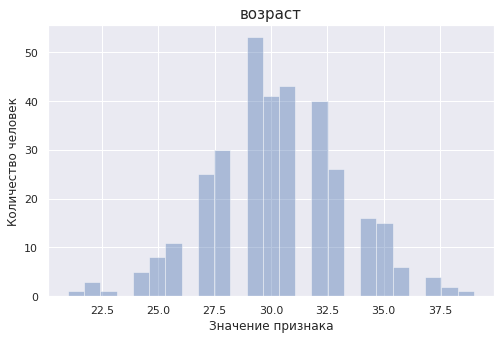

Кластер 1


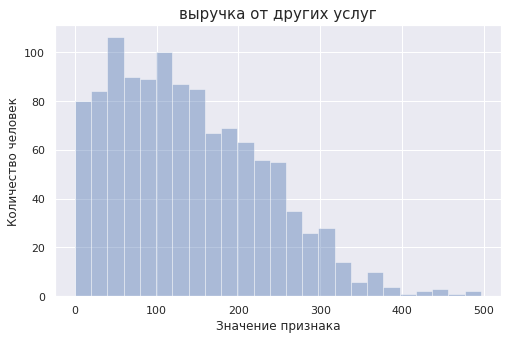

Кластер 2


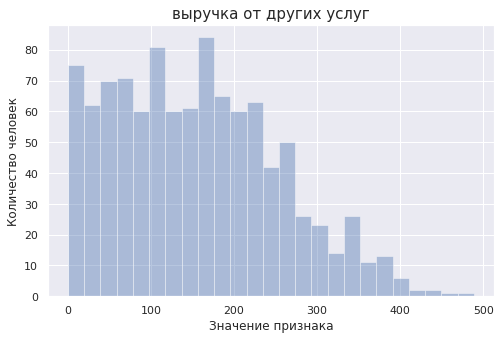

Кластер 3


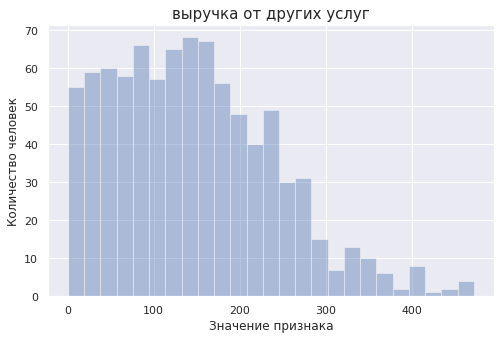

Кластер 4


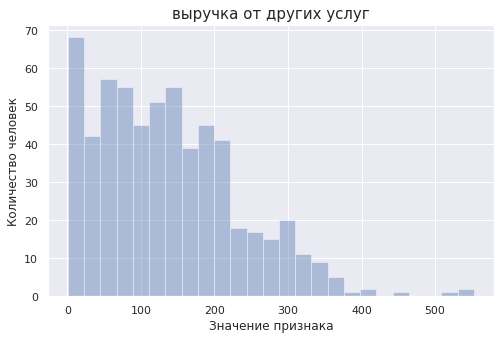

Кластер 5


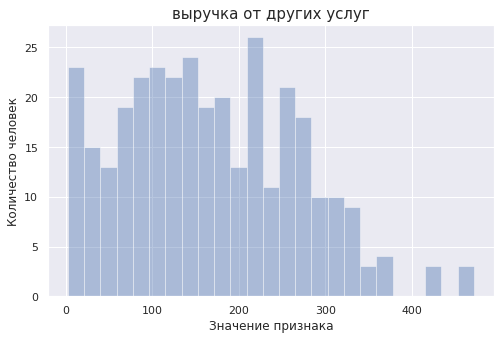

Кластер 1


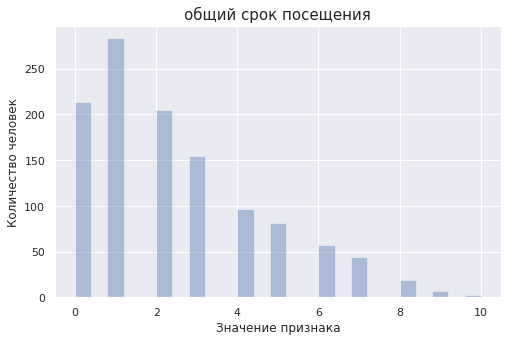

Кластер 2


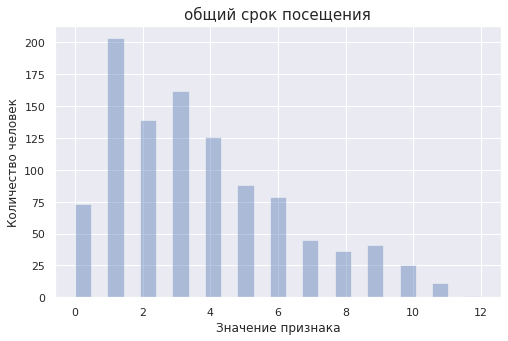

Кластер 3


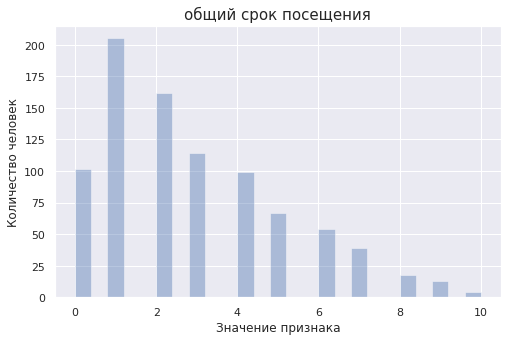

Кластер 4


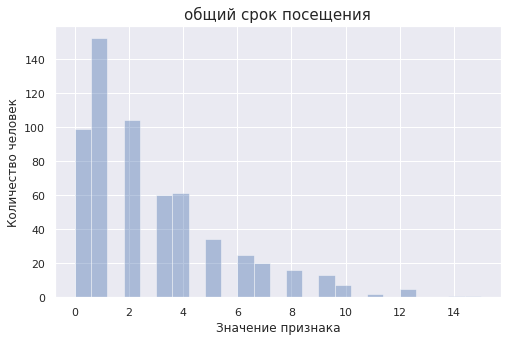

Кластер 5


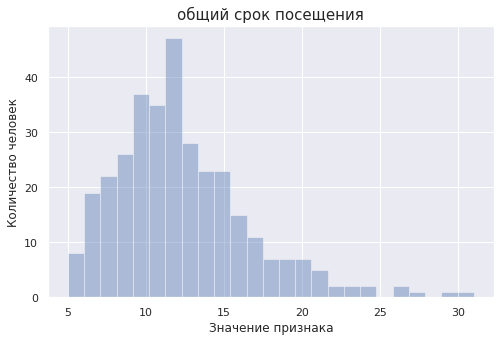

Кластер 1


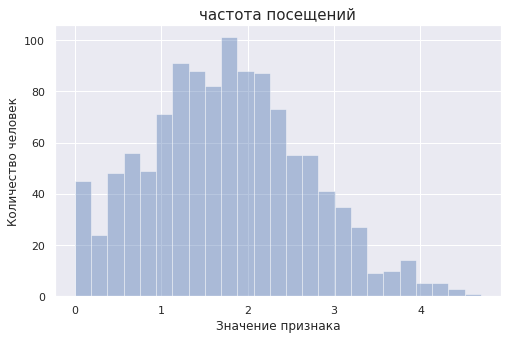

Кластер 2


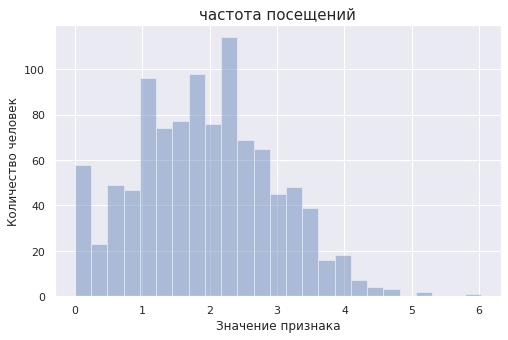

Кластер 3


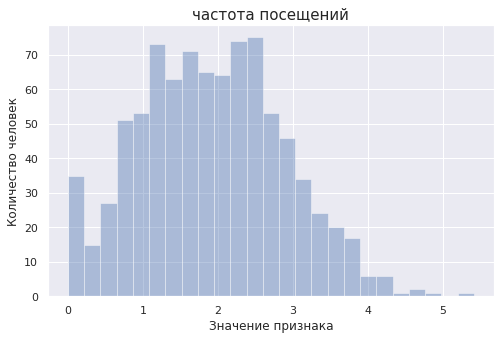

Кластер 4


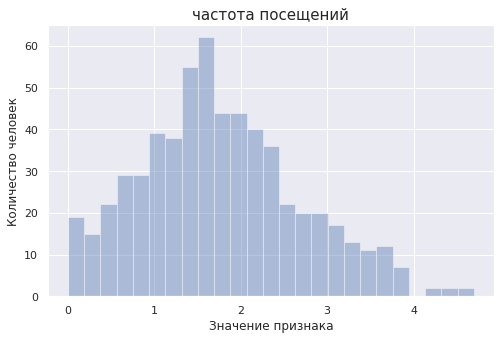

Кластер 5


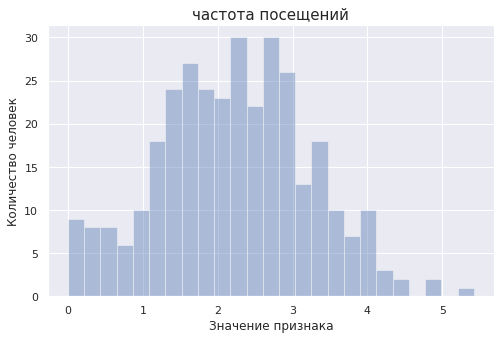

In [127]:
for feature, name in zip(X_cols, X_cols_rus):
    for cluster in np.sort(X['cluster_km'].unique()):
        print('Кластер', cluster + 1)
        plt.figure(figsize=(8, 5))
        sns.set_style("darkgrid")
        fig = sns.distplot(X.loc[X['cluster_km'] == cluster][feature], kde = False, bins = 25)
        fig.set_title(name, fontsize = 15)
        fig.set_xlabel("Значение признака", fontsize = 12)
        fig.set_ylabel("Количество человек", fontsize = 12)
        plt.show()

In [128]:
print("Численность кластеров:")
cluster_size = X.groupby('cluster_km').agg({'age':'count'}).reset_index()\
                         .rename(columns = {'age':'n'})
display(cluster_size)

Численность кластеров:


,cluster_km,n
0,0,1163
1,1,1029
2,2,877
3,3,600
4,4,331


Изучив распределения признаков в разрезе построенных кластеров, можно сделать следующие выводы:
- в четвертом кластере собраны практически все клиенты со значением "0" признака *расположение возле работы или дома*, т.е. посетители, которым дольше добираться до фитнес-центра;
- основная часть клиентов с признаком *партнер* (примерно 1000 из 1900) находится во втором кластере; максимальная часть "непартнеров" сконцентрирована в первом и третьем кластерах (более 800 и 700 соответственно);
- почти все клиенты, пришедшие по промо-акции, находятся в кластере 2;
- также в кластере 2 собрано более половины посетителей, купивших годовой абонемент; посетители с более короткими сроками абонементов разбросаны по остальным кластерам без возможности выделить особо отличающуюся группу;
- во втором и пятом кластерах примерно поровну клиентов, посещающих и не посещающих групповые занятия, в первом исключительно не посещающие, в третьем - только посещающие;
- распределение по возрасту выглядит примерно одинаково для всех кластеров;
- четвертый кластер выглядит ощутимо хуже по распределению средней выручки, пятый и второй - лучше остальных (распредление сильнее сдвинуто направо);
- пятый кластер безоговорочно лидирует по сроку длительности абонементов;
- существенных различий между распределением частоты посещений в неделю нет, несколько выше она для пятого класса.

Наконец, посчитаем долю оттока для каждого кластера. Поскольку матрица X состоит только из признаков и не содержит целевой переменной, присоединим ее столбец **cluster_km** к датафрейму **gym_churn_new**. Так как столбца с уникальным идентификатором нет, возьмем за него переменную **avg_additional_charges_total**, поскольку она измерена с большой точностью и не дублируется для разных наблюдений:

In [129]:
gym_churn_new['avg_additional_charges_total'].duplicated().sum()

0

In [130]:
gym_churn_new = pd.merge(gym_churn_new, X[['cluster_km', 'avg_additional_charges_total']], \
                         on = ['avg_additional_charges_total'], how = 'left')

In [131]:
gym_churn_new.head(5)

,near_location,partner,promo_friends,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_total,churn,cluster_km
0,1,1,1,6,1,29,14.227470,3,0.020398,0,1
1,1,0,0,12,1,31,113.202938,7,1.922936,0,2
2,1,1,0,1,0,28,129.448479,2,1.859098,0,0
3,1,1,1,12,1,33,62.669863,2,3.205633,0,1
4,1,1,1,1,0,26,198.362265,3,1.113884,0,1


In [132]:
total_churn = gym_churn_new.groupby('cluster_km').agg({'churn':'sum'}).reset_index()
total_churn = pd.merge(total_churn, cluster_size, on = ['cluster_km'], how = 'left')
total_churn['ratio'] = total_churn['churn'] / total_churn['n']    
    
display(total_churn)

,cluster_km,churn,n,ratio
0,0,482,1163,0.414445
1,1,137,1029,0.133139
2,2,197,877,0.224629
3,3,245,600,0.408333
4,4,0,331,0.000000


Таким образом, в пятом кластере нет ни одного клиента с оттоком. Хорошо выглядит и второй кластер всего с 13,3%. Промежуточный результат у третьего кластера - 22,4%. Хуже всего себя показали первый и четвертый кластеры с оттоком в 41,4% и 40,8% соответственно.

#### Вывод

Кластер посетителей с нулевым оттоком (№ 5) характеризуется следующими особенностями:
- самый длинный средний срок с момента первого обращения в фитнес-центр (12,5 мес., в остальных - не выше 3,6 мес.);
- самая высокая средняя частота посещений в неделю (2,2 раза);
- для 95% клиентов фитнес-центр находится рядом с домом или офисом;
- достаточно длинный средний срок абонемента (почти 6 мес.);
- самый малочисленный кластер (8,2%).
Это наиболее лояльная часть клиентов, к тому же и средняя выручка от дополнительных услуг от этой категории самая высокая. 

Ценным для бизнеса также выглядит кластер 2: при оттоке всего в 13,3% он второй по численности (25,7% посетителей). Его характеристики:
- самое большое среднее значение признака *промо-акция* (94%);
- максимальный среди всех кластеров средний срок длительности абонемента (7,4 мес.): более половины всех посетителей, купивших годовой абонемент, находится в этом кластере;
- для 99% клиентов фитнес-центр находится рядом с домом или офисом;
- для 96% клиентов работодатель является партнером клуба;
- вторая по значимости средняя выручка от прочих продаж;
- второе значение средней частоты посещений в неделю (1,93 раза).

Промежуточный по результатам оттока (22,4%) третий кластер показывает средние результаты по большинству основных характеристик: сроку длительности абонемента, выручке от продаж дополнительных услуг, сроку с момента первого обращения в фитнес-центр, частоте посещений в неделю. Его особенности следующие:
- для всех клиентов этого кластера фитнес-центр находится рядом с домом или работой;
- все клиенты посещают групповые занятия;
- низкая доля (около 8%) клиентов, пришедших по промо-акции.
Кластер также третий и по численности (21,9% клиентов).

Два класса с худшими показателями по оттоку (примерно по 41%) - первый и четвертый - обладают общими чертами:
- крайне низкая доля клиентов, пришедших по промо-акции (6% и 7% соответственно);
- самый короткий средний срок абонемента (по 2,9 мес.);
- самый непродолжительный срок с момента первого обращения в фитнес-центр (2,4 и 2,8 мес.);
- самая низкая средняя частота посещений в неделю (1,76 раз).

При этом средняя выручка от продажи дополнительный услуг немного выше в первом кластере (140,1 против 136,8 у.е.). Вероятно, на это повлияла разница в параметре *расположение*: в первом кластере все клиенты ходят в центр возле дома или работы, в четвертом, напротив, все добираются дольше.

# Рекомендации по работе с клиентами

Стратегию работы с клиентами можно предложить, исходя из закономерностей, выявленных для кластеров с минимальным оттоком (№5 и №2). Следует выделить два направления: привлечение новых посетителей, обладающих нужными признаками, а также удержание действующих, в том числе стимуляция по переводу из кластеров №1 и №4 в №2 и №5. Так, можно предложить следующие действия:
- подавляющее большинство лояльных килентов посещает клубы, расположенные рядом с офисом или домом, поэтому следует направить усилия в части привлечения новых клиентов из ближайших жилых домов (если зал находится в спальном районе) или бизнес-центров. Это может быть реклама, начиная от листовок и афиш в соседних домах и заканчивая таргет-рекламой в социальных сетях (группы жильцов определенного дома или работников крупных предприятий/офис-центров, расположенных поблизости);
- повышение интереса к приобретению долгосрочных абонементов: скидки и бонусы, дополнительные привилегии для давних клиентов;
- расширение пакета партнерских программ: лояльные клиенты приходят от работодателей, заключивших партнерское соглашение с клубом. Поэтому следует направить усилия на привлечение новых партнеров, а чтобы укрепить партнерские отношения, можно предлагать своим клиентам бонусы в виде скидок на услуги этих партнеров;
- стимулирование увеличения частоты посещений клуба: скидки на абонементы с большим количеством занятий в единицу времени и безлимитные абонементы. Пропаганда здорового образа жизни на тренировках и в социальных сетях клуба. Повышение интереса клиентов к тренировкам посредством предложения широкого спектра разнообразных занятий, новые форматы тренировок, мастер-классы, проведение праздничных мероприятий.